In [1]:
# Standard Libraries
import os
import math
import json
import datetime
import numpy as np
import time
import nvtx

import argparse

import matplotlib.pyplot as plt

# ------------------------------- CUSTOM FUNCTIONS ------------------------------------------------
# Custom Library
import sys
sys.path.append('../')
    
from proxy_apps.apps.timeseries_prediction import deepDMD, proxyDeepDMD, proxyDeepDMDMGPU, proxyDeepDMDPyTorch, hyperparameters

from proxy_apps.utils.tf import TimingCallback
from proxy_apps.utils.data.main import NpEncoder
from proxy_apps.utils import file_reader, path_handler
from proxy_apps.utils.data.grid import GridNetworkDataHandler, GridNetworkTFDataHandler, GridNetworkNewGen, GridDataGenPyTorch


import functools
import math
import onnx
import onnxruntime as ort
# from tensorflow.keras.utils import Progbar

# ------------------------------- CUSTOM FUNCTIONS ------------------------------------------------
# Custom Library
import sys
sys.path.append('../')
    
from proxy_apps.apps.timeseries_prediction import hyperparameters, deepDMD, proxyDeepDMD, proxyDeepDMDMGPU, proxyDeepDMDPyTorch

from proxy_apps.utils.tf import TimingCallback
from proxy_apps.utils.data.main import NpEncoder
from proxy_apps.utils import file_reader, path_handler
from proxy_apps.utils.data.grid import GridNetworkDataHandler, GridNetworkTFDataHandler, GridNetworkNewGen, TransientDataset, GridDataGenPyTorch

In [2]:
# System Setup
config = file_reader.read_config()

_N_EPOCHS = 20
_BATCH_SIZE = 65536
_APP_NAME = config["info"]["app_name"]
_NROWS = int(config["data"]["n_rows"])
_NCOLS = int(config["data"]["n_cols"])
_REPEAT_COLS = int(config["data"]["repeat_cols"])
_WINDOW_SIZE = int(config["data"]["window_size"])
_SHIFT_SIZE = int(config["data"]["shift_size"])
_STRIDE = int(config["data"]["stride"])
_N_SIGNALS = int(config["data"]["n_signals"])

_DTYPE = config["model"]["dtype"]

_MIXED_PRECISION = False
_ONNX_IMPL = True
_INFERENCE_BS = 8192

_N_GPUS = 1
_N_CPUS = 16

_LABEL = "Baseline"
_SUFFIX =  "gpu" + '_' + \
            "a100" + '_' + \
            'ng' + str(_N_GPUS) + '_' + \
            'nc' + str(_N_CPUS) + '_' + \
            'e' + str(_N_EPOCHS) + '_' + \
            'b' + str(_BATCH_SIZE) + '_' + \
            'r' + str(_REPEAT_COLS) + '_' + \
            'mp' + str(0) + '_' + _LABEL

performance_dict = dict()

# current directory
curr_dir = "./"

# output directory
output_dir = path_handler.get_absolute_path(curr_dir, config["info"]["data_dir"] + config["info"]["name"] + "/" + config["info"]["app_name"] + "/" + _DTYPE + "/R" + str(_REPEAT_COLS) + "/")
model_dir = path_handler.get_absolute_path(curr_dir, config["model"]["model_dir"] + config["info"]["name"] + "/" + config["info"]["app_name"] + "/" + _DTYPE + "/R" + str(_REPEAT_COLS) + "/")

hyper_param_dict = config["model"]["hyperparameters"]
hyper_param_dict['original_dim']       = _REPEAT_COLS * _NCOLS   # input data dimension
hyper_param_dict['num_epochs']         = _N_EPOCHS  # Number of epochs  
hyper_param_dict['batch_size']         = _BATCH_SIZE

hyper_param_dict['dtype']         = _DTYPE
hp = hyperparameters.HyperParameters(hyper_param_dict)
hp.model_name         = _LABEL

performance_dict["n_epochs"] = hp.ep
performance_dict["batch_size"] = hp.bs

In [3]:
if _LABEL == "PyTorch":
    import torch
    print("[INFO] PyTorch version: ", torch.__version__)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    
    if _DTYPE == "float64": torch.set_default_dtype(torch.float64)
    else: torch.set_default_dtype(torch.float32)
        
    def get_indexer(n_rows, window_size, shift_size, start_point, leave_last):
        return np.arange(window_size)[None, :] + start_point + shift_size*np.arange(((n_rows - window_size - leave_last - start_point) // shift_size) + 1)[:, None]
else:   
    import tensorflow as tf
    import tf2onnx

    # TensorFlow Setup
    print("[INFO] Tensorflow version: ", tf.__version__)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    for gpu in logical_gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)

    # tf.compat.v1.disable_eager_execution()
    print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

    # Setup TensorFlow
    tf.keras.backend.clear_session()
    tf.config.optimizer.set_jit(True) # Enable XLA.

    # Setup Precision
    if _LABEL in ["Baseline"]: 
        tf.keras.backend.set_floatx('float64')
    elif _LABEL in ["TFDataGen", "TFDataOptMGPU", "TFDataOptMGPUAcc"]:
        tf.keras.backend.set_floatx(_DTYPE)
        if _MIXED_PRECISION:
            # set floatx
            _DTYPE = 'float32'
            hp.d_type         = _DTYPE
            tf.keras.backend.set_floatx(_DTYPE)
            # set policy
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            # check dtypes
            print('Compute dtype: %s' % policy.compute_dtype)
            print('Variable dtype: %s' % policy.variable_dtype)

    # Mirror Strategy for MGPUs
    if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
        mirrored_strategy = tf.distribute.MirroredStrategy()

    # To avoid GPU Congestion
    os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

    @tf.function(experimental_compile=True)
    def get_indexer(n_rows, window_size, shift_size, start_point, leave_last):
        return np.arange(window_size)[None, :] + start_point + shift_size*np.arange(((n_rows - window_size - leave_last - start_point) // shift_size) + 1)[:, None]

[INFO] Tensorflow version:  2.4.0
[INFO] Eager mode:  True


In [4]:
# ------------------------------- CREATE DATA HANDLER ------------------------------------------------   

data_handler_nvtx = nvtx.start_range("Create Data Handler")
dh_start = time.time()    
inp_data_dir = config["info"]["input_dir"]
if _LABEL in ["Baseline", "TFDataOpt"]:
    data_handler = GridNetworkDataHandler(scenario_dir=path_handler.get_absolute_path(curr_dir, inp_data_dir),
                                            n_rows=_NROWS,
                                            n_cols=_NCOLS,
                                            repeat_cols=_REPEAT_COLS,
                                            dtype=_DTYPE
                                         ) 

    scenario_data = data_handler.load_grid_data()

    # ------------------------------- DATA PREPROCESSING ------------------------------------------------

    # Yp, Yf = data_handler.create_inference_windows(scenario_data)
    X_data, Y_data = data_handler.create_windows(scenario_data)

    # ------------------------------- DATA NORMALIZATION ------------------------------------------------

    # Yp_array, Yf_array = data_handler.scale_inference_data(Yp, Yf)
    X_array, Y_array = data_handler.scale_data(X_data, Y_data)

elif _LABEL in ["TFDataGen", "TFDataOptMGPU", "TFDataOptMGPUAcc"]:
    if _ONNX_IMPL:
        data_handler = GridNetworkDataHandler(scenario_dir=path_handler.get_absolute_path(curr_dir, inp_data_dir),
                                            n_rows=_NROWS,
                                            n_cols=_NCOLS,
                                            repeat_cols=_REPEAT_COLS,
                                            dtype=_DTYPE
                                         ) 

        scenario_data = data_handler.load_grid_data()

        # ------------------------------- DATA PREPROCESSING ------------------------------------------------

        # Yp, Yf = data_handler.create_inference_windows(scenario_data)
        X_data, Y_data = data_handler.create_windows(scenario_data)

        # ------------------------------- DATA NORMALIZATION ------------------------------------------------

        # Yp_array, Yf_array = data_handler.scale_inference_data(Yp, Yf)
        X_array, Y_array = data_handler.scale_data(X_data, Y_data)
    else:
        data_handler = GridNetworkNewGen(scenario_dir=path_handler.get_absolute_path(curr_dir, inp_data_dir),
                                                n_rows=_NROWS,
                                                n_cols=_NCOLS,
                                                repeat_cols=_REPEAT_COLS,
                                                d_type=_DTYPE
                                             )

        # yp_indexer = get_indexer(_NROWS, _NROWS-1, _SHIFT_SIZE, 0, 1)
        # yf_indexer = get_indexer(_NROWS, _NROWS-1, _SHIFT_SIZE, 1, 0)
        x_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 0, _N_SIGNALS)
        y_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 1, 0)

        # scenario_data = data_handler.get_training_data(yp_indexer, yf_indexer)
        scenario_data = data_handler.get_training_data(x_indexer, y_indexer, deterministic=True)
    
elif _LABEL == "PyTorch":
    if _ONNX_IMPL:
        data_handler = GridNetworkDataHandler(scenario_dir=path_handler.get_absolute_path(curr_dir, inp_data_dir),
                                            n_rows=_NROWS,
                                            n_cols=_NCOLS,
                                            repeat_cols=_REPEAT_COLS,
                                            dtype=_DTYPE
                                         ) 

        scenario_data = data_handler.load_grid_data()

        # ------------------------------- DATA PREPROCESSING ------------------------------------------------

        # Yp, Yf = data_handler.create_inference_windows(scenario_data)
        X_data, Y_data = data_handler.create_windows(scenario_data)

        # ------------------------------- DATA NORMALIZATION ------------------------------------------------

        # Yp_array, Yf_array = data_handler.scale_inference_data(Yp, Yf)
        X_array, Y_array = data_handler.scale_data(X_data, Y_data)
    else:
        scenario_dir=path_handler.get_absolute_path(curr_dir, inp_data_dir)
        dir_list = [scenario_dir + "/" + f + "/" for f in os.listdir(scenario_dir)[:3]]

        # yp_indexer = get_indexer(_NROWS, _NROWS-1, _SHIFT_SIZE, 0, 1)
        # yf_indexer = get_indexer(_NROWS, _NROWS-1, _SHIFT_SIZE, 1, 0)
        x_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 0, _N_SIGNALS)
        y_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 1, 0)

        # test_size = yp_indexer.shape[0] * yp_indexer.shape[1] * len(dir_list)
        test_size = x_indexer.shape[0] * x_indexer.shape[1] * len(dir_list)

        # dataset = GridDataGenPyTorch(dir_list, _NROWS, _NCOLS, _REPEAT_COLS, yp_indexer, yf_indexer)
        # test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=test_size)  
        test_data = GridDataGenPyTorch(dir_list, _NROWS, _NCOLS, _REPEAT_COLS, x_indexer, y_indexer)
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=_INFERENCE_BS)    

dh_stop = time.time()
performance_dict['data_handler_time'] = dh_stop-dh_start
nvtx.end_range(data_handler_nvtx)

[INFO]: Loading the datasets from the directory: /qfs/people/jain432/pacer/data/TrainingDataIEEE68bus
[INFO]: Loading data for 30 scenarios ...
[INFO]: Loaded 30/30 scenarios ...
[INFO]: Total number of scenarios loaded: 30
[INFO]: Shape of each scenario loaded:  (1400, 1360)
[INFO]: Done ...
Done processing 30/30 datasets ...
[INFO]: Original dataset size: 1400
[INFO]: Chosen dataset size: 800
[INFO]: Length of X_data:  1800
[INFO]: Length of each window after down sampling:  (800, 1360)
[INFO]: X_array shape:  (1440000, 1360)
[INFO]: Y_array shape:  (1440000, 1360)
680


In [5]:
# for d in scenario_data:
#     print(d.shape)

In [6]:
path_handler.get_absolute_path(model_dir, _SUFFIX)

'/qfs/people/jain432/pacer/models/deepDMD/power_systems/scenarios_30/float64/R10/gpu_a100_ng1_nc16_e20_b65536_r10_mp0_Baseline'

In [14]:
K_model = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir, _SUFFIX))

In [54]:
freq_pred_error_list = []
vol_pred_error_list = []
for X_actual in scenario_data:
    X = X_actual[500:502, :]
    X_scaled = X.copy()
    
    # normalize the data
    scale_factor = 2*np.pi
    X_scaled[:, :1360//2]  = scale_factor * (X[:, :1360//2] - 60)
    X_scaled[:, 1360//2:] = 10 * (X[:, 1360//2:] - 1)
    
    Psi_X = K_model.encoder(X_scaled[:1, :], training=False)
    PSI_X = tf.concat([X_scaled[:1, :], tf.cast(Psi_X, hp.d_type)], 1)
    # 1-time step evolution on observable space:
    prediction = np.matmul(PSI_X, K_model.KO)
    print(prediction.shape)
    
    true_freq = X[1:2, :68]
    pred_freq = 60 + (1 / scale_factor) * prediction[:, :68]
    freq_pred_error = np.sqrt(np.mean(np.square(true_freq - pred_freq)))
    freq_pred_error_list.append(freq_pred_error)
    
    true_voltage = X[1:2, (1360//2):(1360//2)+68]
    pred_voltage = 1 + 0.1 * prediction[:, (1360//2):(1360//2)+68]
    vol_pred_error = np.sqrt(np.mean(np.square(true_voltage - pred_voltage)))
    vol_pred_error_list.append(vol_pred_error)

(1, 64)
(1, 1424)
(1, 1424)
0.0008125413080226986 0.0005938154345194646


(1, 64)
(1, 1424)
(1, 1424)


array([0.00081254])

In [20]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
# print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK,eigenvectorsK] = np.linalg.eig(K_deepDMD)
abs_eigenvaluesK = np.absolute(eigenvaluesK)#.tolist()
abs_eigenvaluesK_sorted = np.sort(abs_eigenvaluesK)[::-1]
idx_eigenvaluesK_sorted = np.argsort(abs_eigenvaluesK)[::-1]
largest_n_eigenvalues = 10
print('[Output] Largest', largest_n_eigenvalues, 'eigenvalues of the Koopman operator')
print('------------------------------')
print(np.around(abs_eigenvaluesK_sorted[0:largest_n_eigenvalues], decimals = 4))

[INFO]: Shape of Koopman operator (1424, 1424)
[INFO]: Norm of Koopman operator 70.98882296316371
[INFO]: Trace of K_deepDMD: 1.5469405504898734
[Output] Largest 10 eigenvalues of the Koopman operator
------------------------------
[1.9204 1.9204 1.9106 1.9106 1.9092 1.9092 1.907  1.907  1.898  1.898 ]


In [29]:
true = X_actual[500:510, :68]
pred = 60+(1/scale_factor)*X_pred[:10, :68]

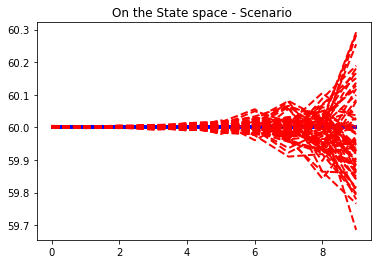

In [30]:
plt.plot(np.arange(10), true, 'b')
plt.plot(np.arange(10), pred, 'r--',linewidth = 2)
plt.title('On the State space - Scenario ')
plt.show()

# # plt.plot(data_window,o_Vm_data[range(end_point,end_point+nts)],'b')
# # plt.plot(data_window,1+0.1*X_pred[:,68:136],'r--',linewidth = 2)
# # plt.title('On the State space - Scenario ' + str(test_scen))
# # plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true, pred)
print(mse)

5.057815352290281e+274


In [18]:
np.sqrt(np.mean(np.square(true - pred), axis=1))

array([0.00000000e+000, 9.65616669e-003, 2.07179200e-002, 3.75780811e-002,
       6.12440790e-002, 1.27602093e-001, 2.29879532e-001, 4.35198597e-001,
       8.24004207e-001, 1.39730700e+000, 2.69679589e+000, 5.84655630e+000,
       9.72277080e+000, 1.81053659e+001, 3.73180334e+001, 6.69535214e+001,
       1.32555647e+002, 2.61161190e+002, 3.96884313e+002, 8.06158536e+002,
       1.83645822e+003, 3.20054837e+003, 6.20718965e+003, 1.20719771e+004,
       2.07534562e+004, 4.10688361e+004, 7.19871885e+004, 1.53811179e+005,
       2.69766790e+005, 4.91426212e+005, 9.68226650e+005, 1.58623739e+006,
       3.58302874e+006, 7.56450489e+006, 1.14666510e+007, 2.18726765e+007,
       5.41491589e+007, 8.87063742e+007, 1.79814748e+008, 3.19105983e+008,
       6.90047239e+008, 1.03311916e+009, 2.27082205e+009, 3.61793400e+009,
       8.75143148e+009, 1.57012471e+010, 2.82327980e+010, 5.97161914e+010,
       9.61283365e+010, 1.73269518e+011, 2.97867659e+011, 6.61004429e+011,
       1.47162292e+012, 2

In [72]:
print(true, pred)

[[60.01310509 60.01336733 60.01314312 ... 59.99460114 59.99529744
  60.02425645]
 [60.01344439 60.01357317 60.01375692 ... 59.99262008 59.99467266
  60.02449405]
 [60.01377608 60.01381505 60.01438396 ... 59.99070123 59.99414582
  60.02465385]
 ...
 [60.00188673 60.00238885 60.00230898 ... 59.99857115 59.99841384
  59.99920727]
 [60.00188124 60.00240226 60.00231099 ... 59.99865476 59.99848123
  59.99917263]
 [60.00186805 60.00240533 60.00230555 ... 59.99874176 59.9985525
  59.99914048]] [[ 6.00131051e+001  6.00133673e+001  6.00131431e+001 ...  5.99946011e+001
   5.99952974e+001  6.00242564e+001]
 [ 5.23520841e+001  5.31601054e+001  4.21695576e+001 ...  1.14842250e+001
  -3.21080663e+001  4.75087245e+001]
 [ 1.60425428e+001  4.88396267e+001  5.94919817e+001 ... -1.71939106e+001
  -3.68478594e+001 -2.77801854e+001]
 ...
 [ 3.53269393e+140  3.56417289e+140  2.86604119e+140 ...  7.04071245e+140
  -6.68837845e+140  3.01041118e+140]
 [-1.05768470e+141 -6.08804032e+140 -2.09264852e+140 ... -1.

In [48]:
X_sample[:1, :].shape

(1, 1360)

In [50]:
Psi_X

<tf.Tensor: shape=(1, 64), dtype=float64, numpy=
array([[ 0.03889353,  0.15695275, -0.25292904,  0.02416481, -0.18614257,
         0.1662427 ,  0.1466191 ,  0.16321775,  0.1741261 , -0.32866705,
        -0.04944772,  0.05444738, -0.08701353, -0.06137395,  0.34878444,
        -0.04926592, -0.0297088 ,  0.20480288, -0.242424  ,  0.01968326,
        -0.25172332,  0.0125362 ,  0.15993956,  0.27172054,  0.18000747,
         0.0254842 , -0.16951441, -0.01228959, -0.24354125,  0.38447215,
        -0.11373239,  0.17380006,  0.15021436,  0.0398318 , -0.10002584,
        -0.10465889, -0.18138068,  0.25041057, -0.26153101, -0.37674222,
         0.12404643, -0.13294811, -0.34491756,  0.05624561, -0.09973732,
         0.18106083,  0.30097408,  0.34590279,  0.15482867, -0.05668979,
        -0.41749866, -0.07513196,  0.25742234,  0.00975031,  0.17803908,
        -0.05197487, -0.13980094, -0.23909916, -0.12063594,  0.12663973,
        -0.43254519, -0.14235045, -0.07235258,  0.4691693 ]])>

In [26]:
if _LABEL == "Baseline":
    K_model = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir, _SUFFIX))
    
    # inference
    Kloss = []
    n_instances = X_array.shape[0] // _INFERENCE_BS
    X_batch = np.array_split(X_array[:_INFERENCE_BS*n_instances], n_instances)
    Y_batch = np.array_split(Y_array[:_INFERENCE_BS*n_instances], n_instances)
    inf_time_start = time.time()
    for X_sample, Y_sample in zip(X_batch, Y_batch):
        Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_value = K_model.predict([X_sample, Y_sample], batch_size=_INFERENCE_BS)
        Kloss.append(Kloss_value)
    inf_time_stop = time.time()    
    # print(Psi_X.shape, PSI_X.shape, Psi_Y.shape, PSI_Y.shape, Kloss.shape)
    
    # performance_dict["inference_size"] = Yp_array.shape[0]
    performance_dict["inference_time"] = inf_time_stop - inf_time_start
    performance_dict["test_Kloss_model"] = Kloss
      
elif _LABEL in ["TFDataGen", "TFDataOptMGPU", "TFDataOptMGPUAcc"]:
    if _ONNX_IMPL:
        print(path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx"))
        tf_model = ort.InferenceSession(path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx"))
        encoder = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir, _SUFFIX))

        Kloss = []
        n_instances = X_array.shape[0] // _INFERENCE_BS
        X_batch = np.array_split(X_array[:_INFERENCE_BS*n_instances].astype(hp.d_type), n_instances)
        Y_batch = np.array_split(Y_array[:_INFERENCE_BS*n_instances].astype(hp.d_type), n_instances)
        inf_time_start = time.time()
        for X_sample, Y_sample in zip(X_batch, Y_batch):
            # print(X_sample.shape, Y_sample.shape)
            Psi_X = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: X_sample})[0]
            Psi_Y = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: Y_sample})[0]

            PSI_X    = tf.concat([X_sample, tf.cast(Psi_X, hp.d_type)], 1)
            PSI_Y    = tf.concat([Y_sample, tf.cast(Psi_Y, hp.d_type)], 1) 

            # 1-time step evolution on observable space:
            K_PSI_X  = tf.matmul(PSI_X, encoder.KO) 

            # 1-step Koopman loss on observable space:        
            Kloss_value   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

            # Regularization loss on Koopman operator:
            Reg_loss= tf.math.scalar_mul(hp.rf, tf.norm(encoder.KO, axis = [0,1], ord = 'fro')) 

            # res = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: Y_sample})
            # Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_value = K_model.predict([X_sample, Y_sample], batch_size=_INFERENCE_BS)
            Kloss.append(Kloss_value.numpy())
        inf_time_stop = time.time()    
    else:
        encoder = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir, _SUFFIX))
        test_size = x_indexer.shape[0] * x_indexer.shape[1] * len(data_handler.dir_list)
        print("Test Size: ", test_size)

        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            _INFERENCE_BS = _INFERENCE_BS * mirrored_strategy.num_replicas_in_sync
            print(mirrored_strategy.num_replicas_in_sync)

        test_data = scenario_data.batch(_INFERENCE_BS, drop_remainder=True)
        # test_data = test_data.cache()

        # for multi-gpu, split the data
        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            test_data = mirrored_strategy.experimental_distribute_dataset(test_data)

        inf_time_start = time.time()
        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            trainer = proxyDeepDMDMGPU.NeuralNetworkModel(hp, encoder)
            Kloss = []
            for t in test_data:
                Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_val = trainer.distributed_test_step(t)
                Kloss.append(Kloss_val.numpy())
        else:
            K_model = proxyDeepDMD.NeuralNetworkModel(hp)
            K_model.encoder = encoder
            Kloss = []
            for t in test_data:
                Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_val = K_model.predict(t, batch_size=_INFERENCE_BS)
                Kloss.append(Kloss_val)
        # print(Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss)
        inf_time_stop = time.time()
    
    print("Inference Time: ", inf_time_stop-inf_time_start)
    
    # performance_dict["inference_size"] = test_size
    performance_dict["inference_time"] = inf_time_stop - inf_time_start
    performance_dict["test_Kloss_model"] = Kloss

elif _LABEL == "PyTorch":
    if _ONNX_IMPL:
        tf_model = ort.InferenceSession(path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx"))
        encoder = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir + "onnx/", _SUFFIX + "_onnx"))

        Kloss = []
        n_instances = X_array.shape[0] // _INFERENCE_BS
        X_batch = np.array_split(X_array[:_INFERENCE_BS*n_instances], n_instances).astype(hp.d_type)
        Y_batch = np.array_split(Y_array[:_INFERENCE_BS*n_instances], n_instances).astype(hp.d_type)
        inf_time_start = time.time()
        for X_sample, Y_sample in zip(X_batch, Y_batch):
            Psi_X = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: X_sample})[0]
            Psi_Y = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: Y_sample})[0]

            PSI_X    = tf.concat([X_sample, tf.cast(Psi_X, hp.d_type)], 1)
            PSI_Y    = tf.concat([Y_sample, tf.cast(Psi_Y, hp.d_type)], 1) 

            # 1-time step evolution on observable space:
            K_PSI_X  = tf.matmul(PSI_X, encoder.KO) 

            # 1-step Koopman loss on observable space:        
            Kloss_value   = tf.norm(PSI_Y - K_PSI_X, axis = [0,1], ord = 'fro')

            # Regularization loss on Koopman operator:
            Reg_loss= tf.math.scalar_mul(hp.rf, tf.norm(encoder.KO, axis = [0,1], ord = 'fro')) 

            # res = tf_model.run(None, input_feed={tf_model.get_inputs()[0].name: Y_sample})
            # Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_value = K_model.predict([X_sample, Y_sample], batch_size=_INFERENCE_BS)
            Kloss.append(Kloss_value)
        inf_time_stop = time.time()    
        print("Inference Time: ", inf_time_stop-inf_time_start)
    else:
        K_model = torch.load(path_handler.get_absolute_path(model_dir, _SUFFIX), map_location=device)
        optimizer = torch.optim.Adagrad(K_model.parameters(), lr=hp.lr)
        trainer = proxyDeepDMDPyTorch.NeuralNetworkModel(hp, K_model, optimizer, device)

        inf_time_start = time.time()
        Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = trainer.predict(test_dataloader)
        inf_time_stop = time.time()

    # performance_dict["inference_size"] = test_size
    performance_dict["inference_time"] = inf_time_stop - inf_time_start
    performance_dict["test_Kloss_model"] = Kloss
     
print("Koopman loss: ", Kloss)

print('Psi_X shape:', Psi_X.shape)
print('Psi_Y shape:', Psi_Y.shape)
print('PSI_X shape:', PSI_X.shape)
print('PSI_X shape:', PSI_Y.shape)

if _LABEL in ["Baseline"]:
    K_deepDMD = K_model.KO.numpy()
elif _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
    if _ONNX_IMPL: K_deepDMD = encoder.KO.numpy()
    else: K_deepDMD = trainer.encoder.KO.numpy()
elif _LABEL in ["TFDataGen"]:
    K_deepDMD = K_model.encoder.KO.numpy()
elif _LABEL in ["PyTorch"]:
    if _ONNX_IMPL: K_deepDMD = K_model.KO.numpy()
    else:
        if torch.cuda.device_count() > 1: K_deepDMD = trainer.encoder.module.KO.cpu().data.numpy()
        else: K_deepDMD = trainer.encoder.KO.cpu().data.numpy()
    
print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)

/qfs/people/jain432/pacer/models/deepDMD/power_systems/scenarios_30/float64/R10/gpu_a100_ng1_nc16_e20_b65536_r10_mp0_TFDataOptMGPU.onnx
Inference Time:  74.76259231567383
Koopman loss:  [1476.5338332118351, 1474.8093597151374, 1474.5320823898232, 1474.5763575231156, 1474.7359027087903, 1475.951769929042, 1475.0850525814446, 1473.0086336115896, 1472.3111791246201, 1472.621995109185, 1472.903957167874, 1474.360071340889, 1475.596292695343, 1474.4028614287174, 1474.4828487683835, 1474.6730729537292, 1474.7500992400733, 1475.2339871506408, 1475.9549024396242, 1474.6690226722294, 1474.4767677510943, 1474.616022122719, 1474.8522554288618, 1478.0056700486175, 1476.9376093979286, 1475.9047156134357, 1475.322150335797, 1475.2023403560893, 1475.326457350214, 1473.6336035068398, 1472.3300447748888, 1472.6811655773488, 1473.2565175264872, 1473.6485487674183, 1474.0333558932664, 1474.3672978470022, 1474.0621591643692, 1474.1584866045862, 1474.5070208071184, 1474.816712651875, 1475.0250530166925, 14

In [23]:
tf_model.get_inputs()

In [18]:
tf_model.KO

AttributeError: 'InferenceSession' object has no attribute 'KO'

In [14]:
Psi_X

[array([[ 0.3584679 , -0.35451121, -0.19742742, ...,  0.63062228,
          0.16466774, -0.20814444],
        [ 0.3584836 , -0.35459771, -0.19747718, ...,  0.63058373,
          0.1646974 , -0.20819372],
        [ 0.3584963 , -0.35467823, -0.19752379, ...,  0.63054654,
          0.16472336, -0.2082369 ],
        ...,
        [ 0.35779349, -0.35355369, -0.19742723, ...,  0.63117904,
          0.16425268, -0.20718148],
        [ 0.35780183, -0.35358168, -0.19744011, ...,  0.63116507,
          0.16426312, -0.20720567],
        [ 0.35781036, -0.35361014, -0.19745366, ...,  0.63115142,
          0.16427369, -0.20722982]])]

In [7]:
len(X_batch)

175

In [7]:
performance_dict

{'n_epochs': 20,
 'batch_size': 65536,
 'data_handler_time': 0.6131823062896729,
 'inference_time': 58.371277809143066,
 'test_Kloss_model': [61.112448449770966,
  34.86950358999813,
  21.058687113362044,
  14.359497257929952,
  11.693853284936946,
  42.00541714721199,
  61.698960150223826,
  34.47326731317706,
  21.195942189633104,
  12.703181203471996,
  8.81594986352653,
  23.29078099022695,
  31.89932005009393,
  19.81281861364859,
  14.136849965847018,
  11.281858474250809,
  10.38212897612368,
  37.431768493608146,
  36.05551935831266,
  21.185003440561314,
  13.748637225999698,
  10.971524814094213,
  10.233846196106887,
  39.50225495061105,
  34.063577130104115,
  22.396882988864892,
  15.074068206872653,
  12.021932101753602,
  11.120008848596107,
  53.396510968245806,
  36.63398332850572,
  21.53958216369862,
  13.466654541133474,
  9.890971060287553,
  8.58014871911081,
  36.75387704766827,
  22.394766130040598,
  13.218569475553954,
  10.267136683563033,
  9.804337982331518

In [15]:
map_location = "cpu"
if torch.cuda.is_available(): map_location = None
torch_model = torch.load(path_handler.get_absolute_path(model_dir, _SUFFIX), map_location=map_location)

In [17]:
Kloss = []
n_instances = X_array.shape[0] // _INFERENCE_BS
X_batch = np.array_split(X_array[:_INFERENCE_BS*n_instances], n_instances)
Y_batch = np.array_split(Y_array[:_INFERENCE_BS*n_instances], n_instances)
# inf_time_start = time.time()
# for X_sample, Y_sample in zip(X_batch, Y_batch):

In [ ]:
scenario_dir=path_handler.get_absolute_path(curr_dir, config["info"]["input_dir"])
dir_list = [scenario_dir + "/" + f + "/" for f in os.listdir(scenario_dir)]

x_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 0, _N_SIGNALS)
y_indexer = get_indexer(_NROWS, _WINDOW_SIZE, _SHIFT_SIZE, 1, 0)

dataset = GridDataGenPyTorch(dir_list, _NROWS, _NCOLS, _REPEAT_COLS, x_indexer, y_indexer)  
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=_BATCH_SIZE, pin_memory=True, num_workers=int(_N_CPUS))

In [ ]:
torch.zeros(X_batch[0].shape)

In [ ]:
torch.tensor(X_batch[0])

In [ ]:
torch_model(torch.tensor(X_batch[0]), False)

In [13]:
# Export the model
torch.onnx.export(torch_model,               # model being run
                  (torch.tensor(X_batch[0]), False),
                  "test.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  training=False
                 )

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
Psi_X

In [ ]:
for i in res:
    print(i.shape)

In [ ]:
for i in tf_model.get_inputs():
    print(i)

In [ ]:
if _LABEL in ["TFDataGen", "TFDataOptMGPU", "TFDataOptMGPUAcc"]:
    if ONNX_IMPL:
        sess_ort = ort.InferenceSession(path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx"))
    else:
        encoder = tf.keras.models.load_model(path_handler.get_absolute_path(model_dir, _SUFFIX))
        test_size = x_indexer.shape[0] * x_indexer.shape[1] * len(data_handler.dir_list)
        print("Test Size: ", test_size)

        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            _INFERENCE_BS = _INFERENCE_BS * mirrored_strategy.num_replicas_in_sync
            print(mirrored_strategy.num_replicas_in_sync)

        test_data = scenario_data.batch(_INFERENCE_BS, drop_remainder=False).take(2)
        # test_data = test_data.cache()

        # for multi-gpu, split the data
        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            test_data = mirrored_strategy.experimental_distribute_dataset(test_data)

        inf_time_start = time.time()
        if _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
            trainer = proxyDeepDMDMGPU.NeuralNetworkModel(hp, encoder)
            Kloss = []
            for t in test_data:
                Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_val = trainer.distributed_test_step(t)
                Kloss.append(Kloss_val.numpy())
        else:
            K_model = proxyDeepDMD.NeuralNetworkModel(hp)
            K_model.encoder = encoder
            Kloss = []
            for t in test_data:
                Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss_val = K_model.predict(t, batch_size=_INFERENCE_BS)
                Kloss.append(Kloss_val)
        # print(Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss)
        inf_time_stop = time.time()
    
elif _LABEL == "PyTorch":
    
    K_model = torch.load(path_handler.get_absolute_path(model_dir, _SUFFIX), map_location=device)
    optimizer = torch.optim.Adagrad(K_model.parameters(), lr=hp.lr)
    trainer = proxyDeepDMDPyTorch.NeuralNetworkModel(hp, K_model, optimizer, device)
    
    inf_time_start = time.time()
    Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = trainer.predict(test_dataloader)
    inf_time_stop = time.time()
    
print("Koopman loss: ", Kloss)

print('Psi_X shape:', Psi_X.shape)
print('Psi_Y shape:', Psi_Y.shape)
print('PSI_X shape:', PSI_X.shape)
print('PSI_X shape:', PSI_Y.shape)

if _LABEL in ["Baseline"]:
    K_deepDMD = K_model.KO.numpy()
elif _LABEL in ["TFDataOptMGPU", "TFDataOptMGPUAcc"]:
    K_deepDMD = trainer.encoder.KO.numpy()
elif _LABEL in ["TFDataGen"]:
    K_deepDMD = K_model.encoder.KO.numpy()
elif _LABEL in ["PyTorch"]:
    if torch.cuda.device_count() > 1: K_deepDMD = trainer.encoder.module.KO.cpu().data.numpy()
    else: K_deepDMD = trainer.encoder.KO.cpu().data.numpy()
    
print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)

In [ ]:
torch_model.eval()

In [ ]:
test_model = Encoder(hp)

In [ ]:

# torch_out = torch_model(x, training=False)

In [ ]:
sess_ort = ort.InferenceSession("test.onnx")

In [ ]:
path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx")

In [ ]:
model = ort.InferenceSession(path_handler.get_absolute_path(model_dir, _SUFFIX + ".onnx"))

In [ ]:
model.

In [ ]:
from tf2onnx.tfonnx import process_tf_graph, tf_optimize
import tensorflow as tf
from tensorflow.compat.v1.graph_util import convert_variables_to_constants as freeze_graph

In [ ]:
print("generating mnist.onnx in python script")
graph_def = freeze_graph(sess_tf, sess_tf.graph_def, [output_tensor.name[:-2]])
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    onnx_graph = process_tf_graph(graph, opset=7, input_names=[input_tensor.name], output_names=[output_tensor.name])
model_proto = onnx_graph.make_model("test")
print("ONNX model is saved at ./output/mnist4.onnx")
with open("./output/mnist4.onnx", "wb") as f:
    f.write(model_proto.SerializeToString())